# **Objective**
Develop a robust time‐series forecasting model to accurately predict [e.g. weekly sales/demand] over the next horizon, so that stakeholders can optimize inventory planning, reduce stockouts, and improve overall operational efficiency.

In [50]:
import pandas as pd

df = pd.read_csv('/content/dc.csv') # CSV file available in https://www.kaggle.com/datasets/ahmedadam415/digital-currency-time-series

In [10]:
df = df.rename(columns = {'Unnamed: 0' : 'Time'}) # Rename the Unnamed column to 'Time'
df['Time'] = pd.to_datetime(df['Time']) # Convert the Time into datetime format
df = df.iloc[::-1].set_index('Time')

df.head()

,open_SAR,open_USD,high_SAR,high_USD,low_SAR,low_USD,close_SAR,close_USD,volume
Time,,,,,,,,,
2018-05-07,36232.689408,9661.02,36340.138368,9689.67,34432.422400,9181.00,35122.496000,9365.00,33787
2018-05-08,35122.496000,9365.00,35537.665280,9475.70,33980.649216,9060.54,34457.025024,9187.56,25533
2018-05-09,34421.171200,9178.00,35216.256000,9390.00,33622.336000,8965.00,34916.224000,9310.00,25673
2018-05-10,34916.224000,9310.00,35235.458048,9395.12,33641.088000,8970.00,33761.850880,9002.20,25055
2018-05-11,33761.888384,9002.21,33816.606720,9016.80,31282.086400,8341.00,31503.360000,8400.00,48227


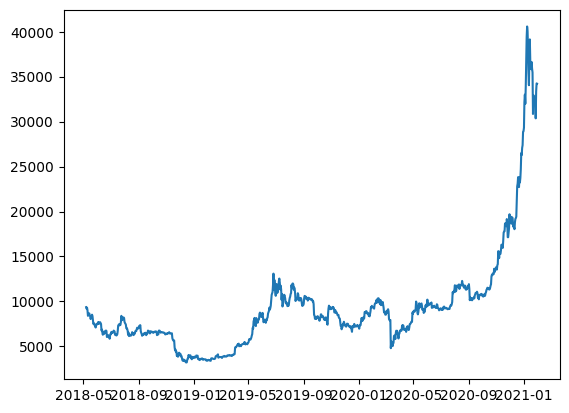

In [12]:
import matplotlib.pyplot as plt
plt.plot(df['close_USD'])
plt.show()

In [13]:
# Split the data
train = df.iloc[:-200] # all rows of the original df except for the last 200 rows.
test = df.iloc[-200:]  # only the last 200 rows of the original df

In [15]:
from statsmodels.tsa.arima.model import ARIMA
# create an instance of the ARIMA model.
model = ARIMA(train['close_USD'], order=(2, 1, 0))
results = model.fit()

# generate future predictions using the fitted model.
forecast = results.forecast(steps=200)
forecast

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


,predicted_mean
2020-07-15,9252.006931
2020-07-16,9252.942627
2020-07-17,9252.688291
2020-07-18,9252.752780
2020-07-19,9252.735700
...,...
2021-01-26,9252.739185
2021-01-27,9252.739185
2021-01-28,9252.739185
2021-01-29,9252.739185


In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Calculate and print evaluation metrics for the forecast
mae = mean_absolute_error(test['close_USD'], forecast)
mse = mean_squared_error(test['close_USD'], forecast)
rmse = np.sqrt(mse)
mape = (forecast - test['close_USD']).abs().div(test['close_USD']).mean()

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

MAE: 7956.23
RMSE: 11705.11
MAPE: 0.35%


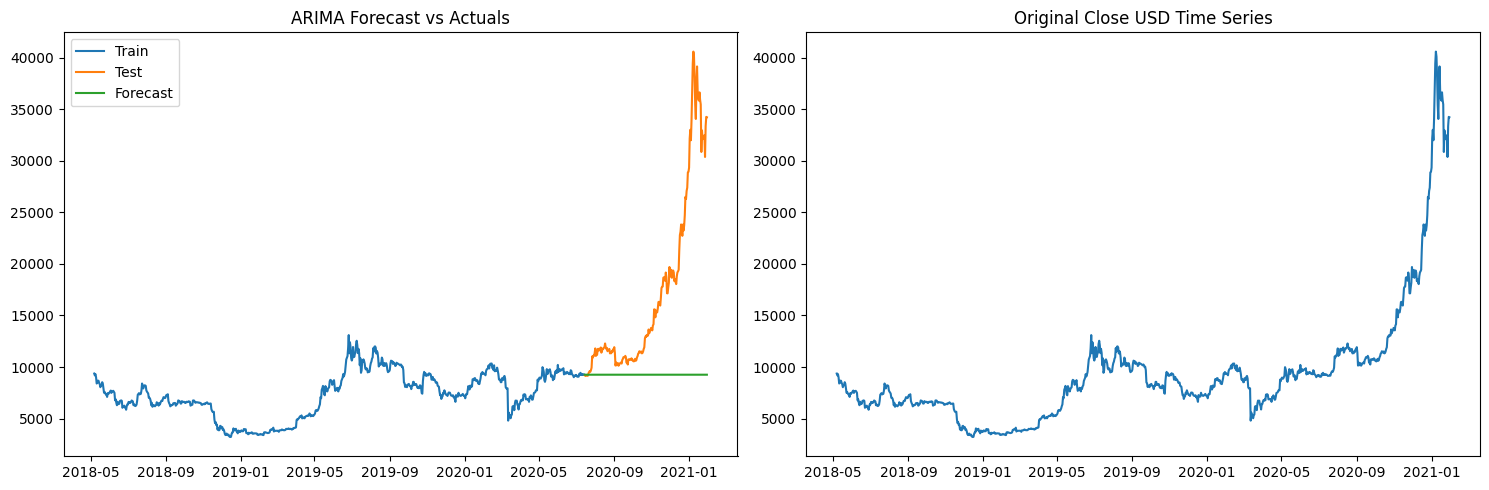

In [22]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Train, Test, and Forecast
axes[0].plot(train.index, train['close_USD'], label='Train')
axes[0].plot(test.index, test['close_USD'], label='Test')
axes[0].plot(forecast.index, forecast, label='Forecast')
axes[0].legend()
axes[0].set_title('ARIMA Forecast vs Actuals')

# Plot 2: Original 'close_USD' time series
axes[1].plot(df.index, df['close_USD'])
axes[1].set_title('Original Close USD Time Series')

plt.tight_layout()
plt.show()

The forecast was worse as our model can’t forecast the increasing trend. The model ARIMA that we use seems too simple for forecasting.

Therefore, it’s better if we use another model outside of statsmodels. Let’s try out the famous prophet package from Facebook. Prophet is a time series forecasting model package that works best on data with seasonal effects.

In [ ]:
pip install prophet

In [52]:
df_prophet = df.reset_index()[["Time", "close_USD"]].rename(
    columns={"Time": "ds", "close_USD": "y"}
) # resets the DataFrame's index (which was previously the 'Time' column) back to a default integer index. The 'Time' column is converted back into a regular column.
df_prophet.head()

,ds,y
0,0,34218.54
1,1,34252.20
2,2,33364.86
3,3,30366.15
4,4,32467.77


In [45]:
import pandas as pd
from prophet import Prophet

model = Prophet()
# Fit the model
model.fit(df_prophet)

# create date to predict
future_dates = model.make_future_dataframe(periods=365)

# generates the forecast using the fitted model and the future_dates DataFrame
predictions = model.predict(future_dates)

predictions.head()

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/b1br8bak.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/rysv42x5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23702', 'data', 'file=/tmp/tmpc_tpepdt/b1br8bak.json', 'init=/tmp/tmpc_tpepdt/rysv42x5.json', 'output', 'file=/tmp/tmpc_tpepdt/prophet_modele5x7amvt/prophet_model-20250722120219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:02:19 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-05-07,2919.153990,5932.928023,8545.726759,2919.153990,2919.153990,4270.014799,4270.014799,4270.014799,9.556417,9.556417,9.556417,4260.458382,4260.458382,4260.458382,0.0,0.0,0.0,7189.168789
1,2018-05-08,2936.842326,6066.602626,8564.773881,2936.842326,2936.842326,4323.932682,4323.932682,4323.932682,-18.061121,-18.061121,-18.061121,4341.993803,4341.993803,4341.993803,0.0,0.0,0.0,7260.775008
2,2018-05-09,2954.530663,6079.727887,8762.853340,2954.530663,2954.530663,4441.999239,4441.999239,4441.999239,24.504559,24.504559,24.504559,4417.494680,4417.494680,4417.494680,0.0,0.0,0.0,7396.529902
3,2018-05-10,2972.218999,6115.072087,8968.465265,2972.218999,2972.218999,4474.835612,4474.835612,4474.835612,-11.128537,-11.128537,-11.128537,4485.964149,4485.964149,4485.964149,0.0,0.0,0.0,7447.054611
4,2018-05-11,2989.907336,6239.779851,8939.646248,2989.907336,2989.907336,4551.854837,4551.854837,4551.854837,5.332431,5.332431,5.332431,4546.522406,4546.522406,4546.522406,0.0,0.0,0.0,7541.762173


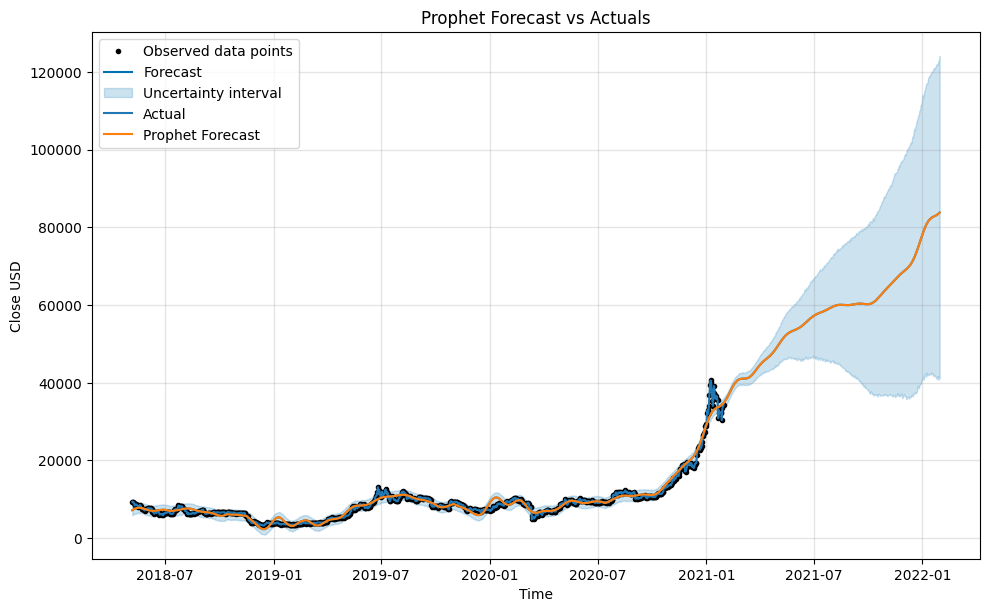

In [46]:
model.plot(predictions) # It uses the built-in plotting function of the Prophet model to generate a plot of the forecast. This plot typically shows the actual data points, the forecast line, and the uncertainty intervals around the forecast.
plt.plot(df_prophet['ds'], df_prophet['y'], label='Actual')
plt.plot(predictions['ds'], predictions['yhat'], label='Prophet Forecast')
plt.xlabel('Time')
plt.ylabel('Close USD')
plt.title('Prophet Forecast vs Actuals')
plt.legend()
plt.show()

In summary, the above plot visualizes how well the Prophet model's predictions align with the actual historical data.

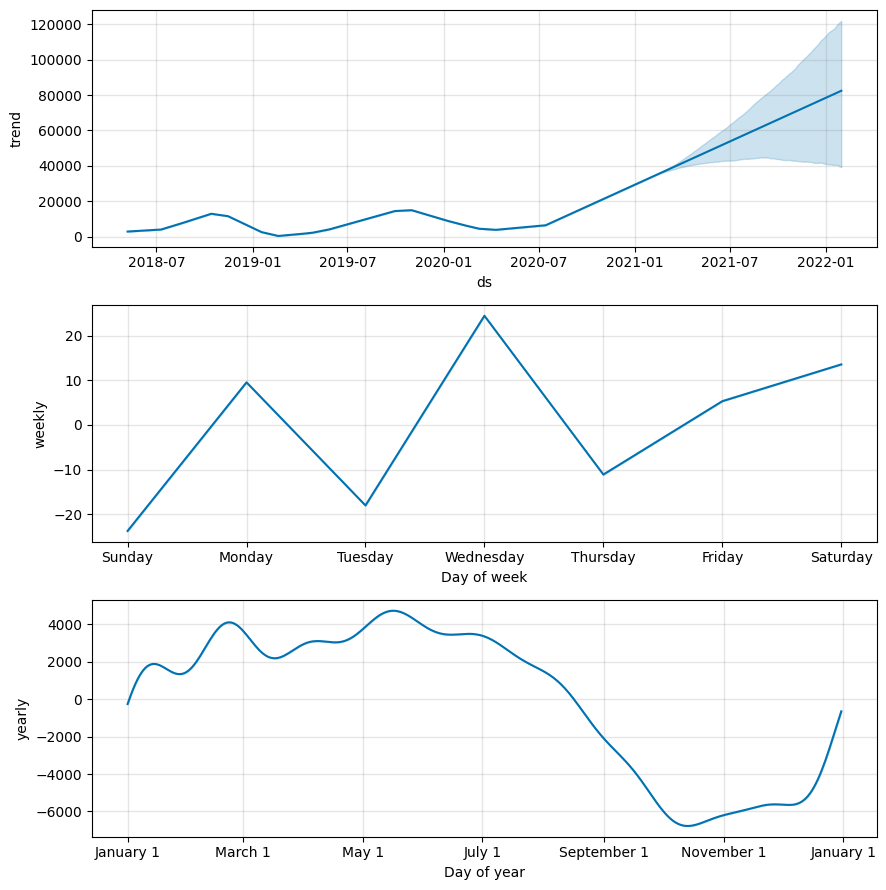

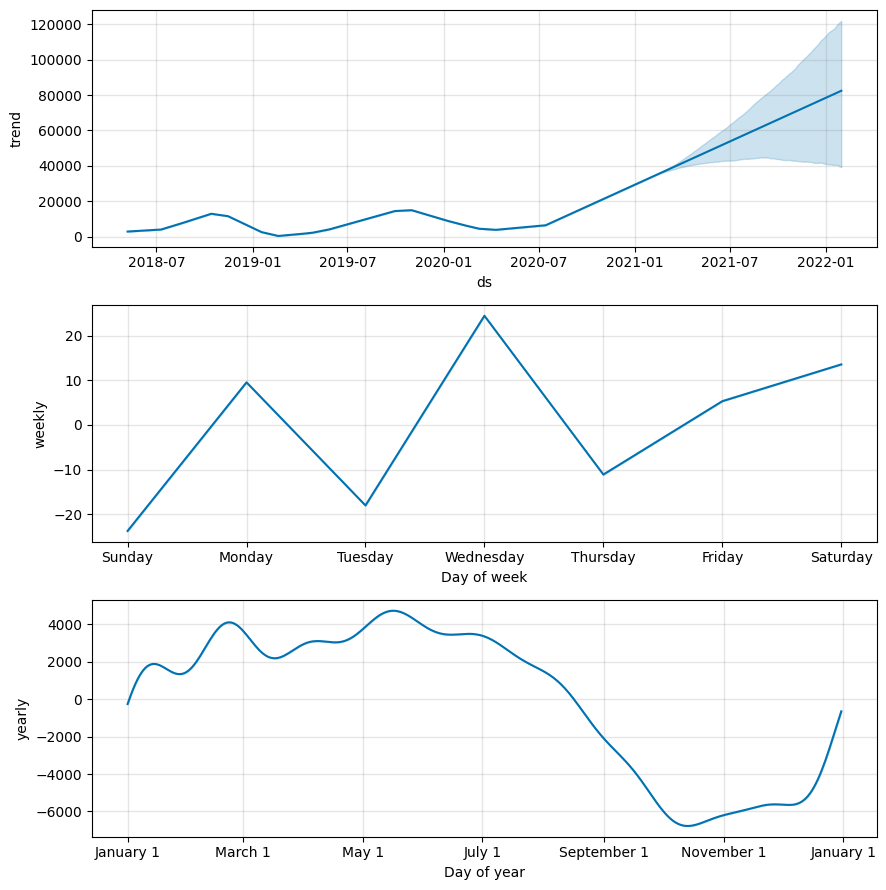

In [47]:
model.plot_components(predictions)

Prophet includes a diagnostic measurement that we can use: time series cross-validation. The method uses part of the historical data and fits the model each time using data up to the cutoff point. Then the Prophet would compare the predictions with the actual ones. Let’s try using the code.

In [48]:
from prophet.diagnostics import cross_validation, performance_metrics

# Perform time series cross-validation
# initial: the size of the initial training period
# period: the spacing between cutoff dates
# horizon: the forecast horizon
df_crossval = cross_validation(model, initial='365 days', period='180 days', horizon = '365 days')

# Calculate evaluation metrics from the cross-validation results
result = performance_metrics(df_crossval)

result

INFO:prophet:Making 2 forecasts with cutoffs between 2019-08-04 00:00:00 and 2020-01-31 00:00:00


  0%|          | 0/2 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/zxlfm0k8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/e1ex8sln.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=92388', 'data', 'file=/tmp/tmpc_tpepdt/zxlfm0k8.json', 'init=/tmp/tmpc_tpepdt/e1ex8sln.json', 'output', 'file=/tmp/tmpc_tpepdt/prophet_modelle4ev0gx/prophet_model-20250722120822.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
12:08:22 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
12:08:22 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/lr653gqq.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc_tpepdt/fo_c9tzk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,7.925838e+05,890.271744,730.114945,0.073326,0.075506,0.075800,0.493151
1,38 days,7.998562e+05,894.346811,729.473486,0.073914,0.072847,0.076027,0.506849
2,39 days,8.036711e+05,896.477036,723.759547,0.074045,0.072132,0.075798,0.520548
3,40 days,7.974396e+05,892.994722,715.292257,0.073962,0.070827,0.075341,0.534247
4,41 days,1.040421e+06,1020.010266,746.409722,0.084070,0.066528,0.081086,0.547945
...,...,...,...,...,...,...,...,...
324,361 days,1.302981e+08,11414.819187,9831.440601,0.490650,0.516569,0.495832,0.547945
325,362 days,1.315811e+08,11470.882396,9891.013641,0.489259,0.506374,0.496241,0.534247
326,363 days,1.339003e+08,11571.528475,9980.795732,0.487567,0.506374,0.497038,0.520548
327,364 days,1.366156e+08,11688.268795,10089.318517,0.486711,0.500150,0.498728,0.506849


/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/usr/local/lib/python3.11/dist-packages/prophet/plot.py:548: FutureWarning: Series.view is deprecated and will be remov

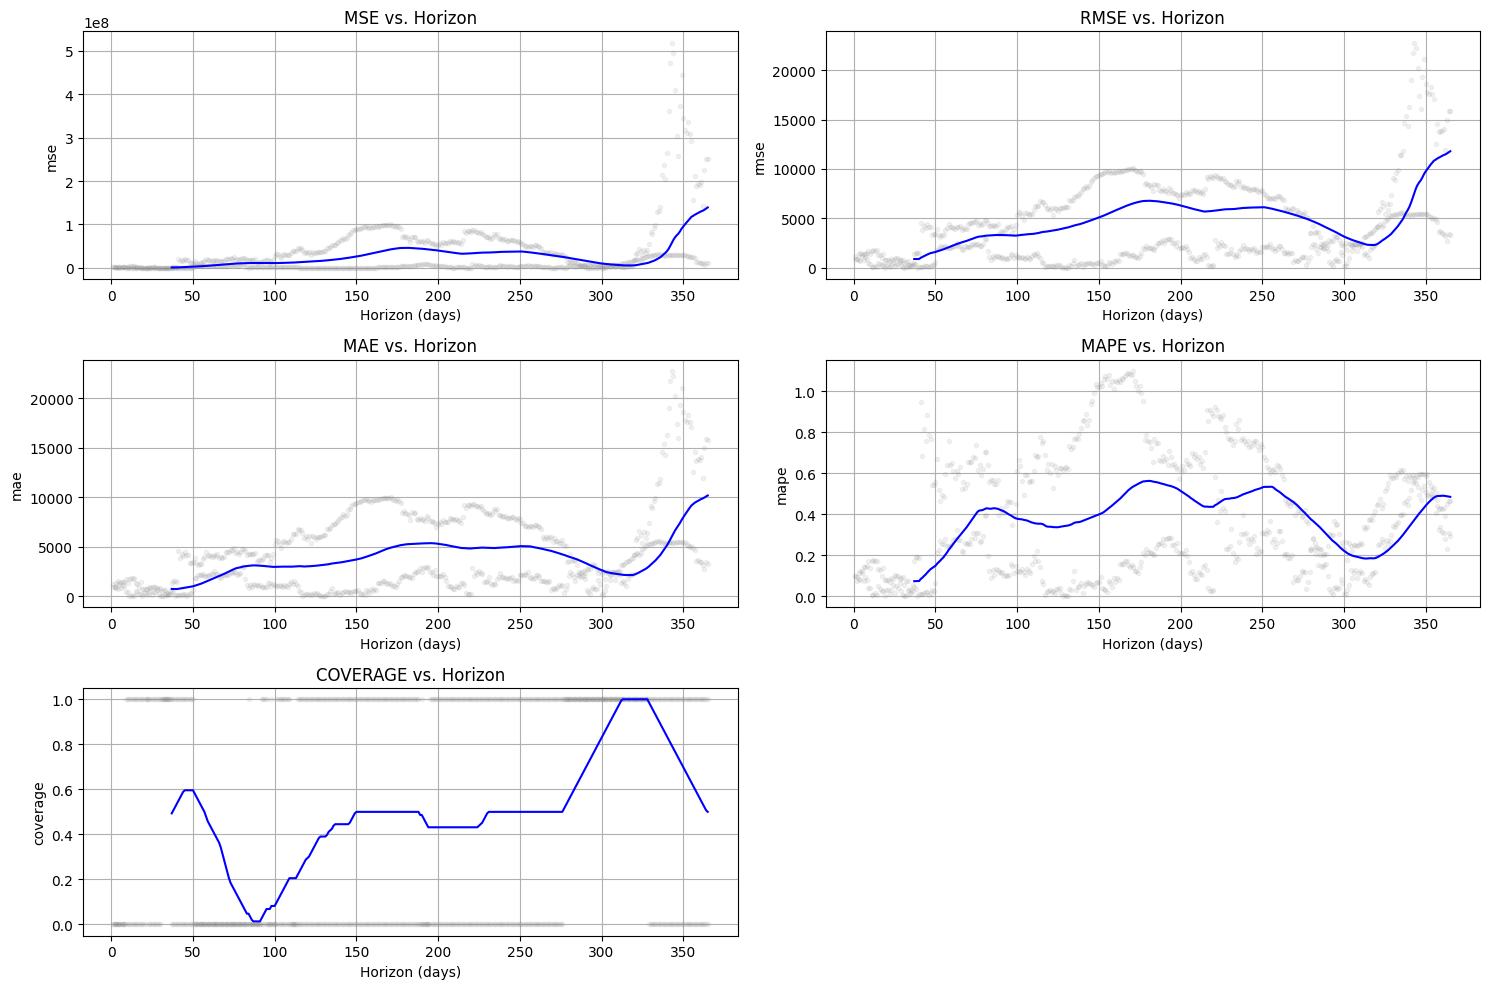

In [49]:
import matplotlib.pyplot as plt
from prophet.plot import plot_cross_validation_metric

metrics_to_plot = ['mse', 'rmse', 'mae', 'mape', 'coverage']
# Create a figure with 3 rows and 2 columns for subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 10))
# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, metric in enumerate(metrics_to_plot):
    plot_cross_validation_metric(df_crossval, metric=metric, ax=axes[i])
    axes[i].set_title(f'{metric.upper()} vs. Horizon')

# Hide any unused subplots
for j in range(len(metrics_to_plot), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Notebook Summary and Conclusion

This notebook performs a time series analysis and forecasting of the 'close_USD' data from the provided dataset. The analysis proceeds through the following key stages:

1.  **Data Loading and Preparation**: The dataset is loaded from a CSV file. The 'Unnamed: 0' column, which represents the time information, is renamed to 'Time', converted to a datetime format, and then set as the DataFrame's index. The data is also reversed to ensure it is in chronological order.

2.  **Initial Visualization**: The 'close_USD' time series is plotted to visualize its trend and patterns over time.

3.  **ARIMA Modeling**: An ARIMA model is implemented to forecast the 'close_USD' values.
    *   The data is split into training and testing sets.
    *   An ARIMA model with order (2, 1, 0) is fitted to the training data.
    *   A forecast is generated for the period covered by the testing set.
    *   Evaluation metrics (MAE, RMSE, MAPE) are calculated to assess the ARIMA model's performance.
    *   The ARIMA forecast is visualized against the actual values in the test set, alongside the original time series. The analysis notes that the ARIMA model struggled to capture the increasing trend.

4.  **Prophet Modeling**: Recognizing the limitations of the ARIMA model for this data's trend, the notebook transitions to using the Prophet library, which is well-suited for time series with strong seasonalities.
    *   The data is prepared in the format required by Prophet ('ds' for datestamp and 'y' for the value to be forecasted).
    *   A Prophet model is initialized and fitted to the data.
    *   A forecast is generated for a future period (365 days beyond the historical data).
    *   The Prophet forecast is visualized against the historical data, showing its ability to capture the overall trend and seasonality.
    *   The components of the Prophet model (trend, weekly seasonality, yearly seasonality) are plotted to understand the underlying patterns identified by the model.

5.  **Prophet Cross-Validation**: To evaluate the Prophet model's performance robustly, time series cross-validation is performed.
    *   The `cross_validation` function is used with specified initial training period, period between cutoffs, and forecast horizon.
    *   Performance metrics (mse, rmse, mae, mape, coverage) are calculated from the cross-validation results for different forecast horizons.
    *   These performance metrics are visualized against the forecast horizon to understand how the model's accuracy changes as the prediction window increases.

**Conclusion:**

The notebook successfully demonstrates the application of two different time series forecasting models, ARIMA and Prophet, to the 'close_USD' data. While the initial ARIMA model with sample parameters did not effectively capture the increasing trend, the Prophet model showed promising results in fitting the historical data and forecasting future values, likely due to its ability to handle trends and seasonalities. The cross-validation analysis provides further insight into the Prophet model's performance across different forecast horizons, highlighting how the error metrics generally increase with a longer horizon, which is typical for time series forecasting.

Overall, the notebook provides a good workflow for time series analysis, including data preparation, visualization, modeling, and evaluation using cross-validation. The results suggest that Prophet is a more suitable model than a basic ARIMA for this specific time series, given its clear trend and potential seasonal patterns. Further steps could involve tuning the Prophet model's parameters, adding holidays or extra regressors, and comparing its performance to other advanced time series models.